In [0]:
#colorado_data - confirmed cases- weekly
#colorado_data1 - deaths in colorado - weekly
#date_confirmed - dataset with date and #Confirmed cases colorado
#date_deaths - dataset with date and death cases colorado
#date_confirmed_denver - dataset with date and confirmed cases in Denver
#date_deaths_denver - dataset with date and death cases in denver


In [0]:
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib.colors as mcolors
import pandas as pd 
import random
import math
import time
from datetime import datetime
import datetime
import operator 
import seaborn as sns
%matplotlib inline

Reading data. We have covid data from https://raw.githubusercontent.com/CSSEGISandData/ and crime data csv files 

In [0]:
# Reading data
confirmed_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv')
deaths_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_US.csv')
recovered_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv')
latest_data = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports/03-29-2020.csv')
denver_crime = pd.read_csv('crime.csv')
offense_codes = pd.read_csv('offense_codes.csv')

******************************** DATA CLEANING ********************************

In [69]:
#dropping irrelevant columns
confirmed_df.head()
data=confirmed_df.drop(['UID', 'code3', 'FIPS', 'Lat', 'Long_','Combined_Key','iso2','iso3'], axis=1)

,Admin2,Province_State,Country_Region,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,...,4/2/20,4/3/20,4/4/20,4/5/20,4/6/20,4/7/20,4/8/20,4/9/20,4/10/20,4/11/20,4/12/20,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20,4/18/20,4/19/20,4/20/20,4/21/20,4/22/20,4/23/20,4/24/20,4/25/20,4/26/20,4/27/20,4/28/20,4/29/20,4/30/20,5/1/20,5/2/20,5/3/20,5/4/20,5/5/20,5/6/20,5/7/20,5/8/20,5/9/20,5/10/20,5/11/20
249,Adams,Colorado,US,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,212,260,294,354,367,388,417,417,475,543,647,693,726,726,758,805,860,915,915,996,1033,1082,1252,1302,1348,1391,1430,1490,1585,1665,1730,1780,1815,1883,1952,2046,2117,2205,2242,2278
250,Alamosa,Colorado,US,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,4,4,4,4,4,4,5,5,5,7,7,7,7,7,7,7,7,7,7,9,9,9,10,10,10,10,10,10,10,10,11,12,14,14,22,25,25,25,25,32
251,Arapahoe,Colorado,US,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,381,441,500,608,652,718,764,764,877,931,1083,1142,1183,1183,1243,1342,1419,1536,1536,1649,1717,1824,2030,2083,2160,2252,2312,2389,2472,2557,2625,2706,2758,2883,2977,3089,3148,3228,3272,3313
252,Archuleta,Colorado,US,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,6,6,6,6,6,6,6,6,6,6,6,6,6,7,7,7,9,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8
253,Baca,Colorado,US,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,3,9,9,9,9,9,9,9,9,9,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,12,12,12,12,12,12,12,12,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
310,Washington,Colorado,US,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,2,2,2,2,5,5,5,5,5,6,6,6,6,6,6,6,6,6,7,7,7,7,8,8,8,9,9,9,9,9,9,9
311,Weld,Colorado,US,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,293,329,379,470,504,537,573,573,614,649,738,808,858,858,928,960,986,1063,1063,1180,1237,1263,1353,1430,1469,1544,1618,1704,1776,1802,1836,1872,1897,1955,1988,2042,2087,2120,2139,2159
312,Yuma,Colorado,US,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,3,3,3,4,5,6,6,6,6,7,8,8,9,8,9,9,9,9,10,10,10,11,11
3154,Out of CO,Colorado,US,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
print(data.isnull().sum().sum())
print(deaths_df.isnull().sum().sum())
print(denver_crime.isnull().sum().sum())
print(offense_codes.isnull().sum().sum())

In [ ]:
print(denver_crime.isnull().sum())

So when we analyse the crime DF columns for null, we see that in many crimes, the last occurence date, address, and latitude, longitudes are missing in several instances. Now, the columns that have null values will not be necessary for out analysis as the coordinates, and when the crime was reported last is not necessary for our inferences. We are more concerned for when the crime is first reported.

Also, adding average or median values imputation in columns like date and latitude/logitude will lead to muddy data as it may lead to thousands of entries on the same date(average of all dates) or at the same locaton(average latitude).

Another point: The neighborhood code can cover the location of crime within the city so the insights will not be lost.


In [ ]:
denver_crime=denver_crime.drop(['GEO_X', 'GEO_Y', 'GEO_LON', 'GEO_LAT','LAST_OCCURRENCE_DATE','INCIDENT_ADDRESS'], axis=1)

In [ ]:
print(denver_crime.isnull().sum())

Now, with the irrelevant columns removed, our crime data is also free of null values. 

### Tukey's test :
In the cells below we have found out the values which are outside the IQR range for the columns and have been removed from the main dataframe. 

In [ ]:
# provides upper and lower limits for a column above which the value will be an outlier 
from statistics import median
def outlier_limits(values, x):
    values = sorted(values, key=float)

    if len(values) >= 2:
        middle = int(round(len(values) / 2.0))
        q1 = median(values[:middle])
        q3 = median(values[middle:])
        iqr = q3 - q1
        lower = q1 - (iqr * x)
        upper = q3 + (iqr * x)
    elif values:
        lower = upper = values[0]
    else:
        lower = upper = 0
    return[lower, upper]

In [ ]:
#extracts only the numerical data from the datasets 
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

denver_crime_numeric_only = denver_crime.select_dtypes(include=numerics)
deaths_numeric_only = deaths_df.select_dtypes(include=numerics)
confirmed_cases_numeric_only = data.select_dtypes(include=numerics)

In [ ]:
# This method calculates the range of tolerance, above and below which lie the outliers, for each column
def calculate_range(df):
    limits = list()
    for column in df:
        temp = list()
        [low, high] = outlier_limits(df[column], 1.5)
        temp.append(low)
        temp.append(high)
        limits.append(temp)
    limits_df = pd.DataFrame(limits, columns=['lower threshold', 'upper threshold'])   
    return [limits, limits_df]

In [ ]:
data.shape

In [ ]:
# this method performs the actual task of finding the outliers and removing the rows with outlying values 
def delete_outliers(df, main_df):
    #data for confirmed cases
    col_names = list() 
    # finding the threshold ranges for each column in the colorado confirmed cases column
    confirmed_cases_numeric_only
    [limits, limits_df] = calculate_range(df)
    # storing the names of each column in a list, so that this can be used to calculate the -
    # - outliers in each column 
    count = 0

    for column in df.columns: 
        col_names.append(column)
    for i in range(0, len(col_names)):
        column_name = col_names[i]
        column_data = main_df[[column_name]]
        limits_for_column = limits[i]
        for j in range(0,len(column_data)):
            if ((column_data.iloc[j][column_name] < limits_for_column[0]) or (column_data.iloc[j][column_name] > limits_for_column[1])):
                #print('Outlier in column ',column_name,' at row number:',j+1,'with the value',column_data.iloc[j][column_name] )
                if ((j < 214) or (j > 315)):
                    main_df.drop([j])
                count += 1

    print(count)

In [ ]:
delete_outliers(confirmed_cases_numeric_only, data)
delete_outliers(deaths_numeric_only, deaths_df)

In [ ]:
data.shape

In [ ]:
#Obtaining the data for just Colorado
colorado_data = data.loc[data['Province_State'] == 'Colorado']
colorado_data

In [70]:
#Table with county name and total number of confirmed cases till May 7th in Colorado
data_df = colorado_data[['Admin2','Province_State','5/7/20']]
data_df.set_index('Admin2', inplace=True)
#dropping irrelevant columns in deaths data
data1=deaths_df.drop(['UID', 'code3', 'FIPS', 'Lat', 'Long_','Combined_Key','iso2','iso3','Population'], axis=1)
#Obtaining the deaths data for just Colorado State
colorado_data1 = data1.loc[data['Province_State'] == 'Colorado']
colorado_data1

,Admin2,Province_State,Country_Region,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,...,4/2/20,4/3/20,4/4/20,4/5/20,4/6/20,4/7/20,4/8/20,4/9/20,4/10/20,4/11/20,4/12/20,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20,4/18/20,4/19/20,4/20/20,4/21/20,4/22/20,4/23/20,4/24/20,4/25/20,4/26/20,4/27/20,4/28/20,4/29/20,4/30/20,5/1/20,5/2/20,5/3/20,5/4/20,5/5/20,5/6/20,5/7/20,5/8/20,5/9/20,5/10/20,5/11/20
249,Adams,Colorado,US,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,2,7,9,10,12,12,14,14,14,23,26,26,27,27,28,29,31,35,35,46,46,50,57,57,58,60,61,62,63,68,68,68,68,72,75,78,80,81,81,81
250,Alamosa,Colorado,US,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
251,Arapahoe,Colorado,US,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,7,10,10,13,15,15,19,19,19,30,38,39,43,43,52,55,58,65,65,80,87,101,125,127,127,130,136,140,141,152,153,156,157,165,167,172,177,176,176,179
252,Archuleta,Colorado,US,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
253,Baca,Colorado,US,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
310,Washington,Colorado,US,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
311,Weld,Colorado,US,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,13,16,16,24,26,26,30,30,30,40,48,53,55,55,57,60,61,64,64,69,69,70,82,82,82,87,88,93,95,100,100,100,102,107,109,113,113,113,113,114
312,Yuma,Colorado,US,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3154,Out of CO,Colorado,US,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,1


In [71]:
#Countywise death cases in Colorado till May 7th
data_df1 = colorado_data1[['Admin2','Province_State','5/7/20']]
data_df1.set_index('Admin2', inplace=True)
#Result table of county wise confirmed and death cases in Colorado
result = pd.merge(data_df, data_df1, on='Admin2')
result1 = result.drop(['Province_State_x'],axis=1)
result2 = result1.rename(columns={"5/7/20_x": "Confirmed", "5/7/20_y": "Deaths", "Province_State_y": "State"})
result2

,Confirmed,State,Deaths
Admin2,,,
Adams,2046,Colorado,78
Alamosa,25,Colorado,2
Arapahoe,3089,Colorado,172
Archuleta,8,Colorado,0
Baca,12,Colorado,0
...,...,...,...
Washington,9,Colorado,0
Weld,2042,Colorado,113
Yuma,10,Colorado,0


In [72]:
#checking the different offense category types
denver_crime.OFFENSE_CATEGORY_ID.unique()

array(['larceny', 'traffic-accident', 'all-other-crimes',
       'public-disorder', 'sexual-assault', 'theft-from-motor-vehicle',
       'burglary', 'other-crimes-against-persons', 'drug-alcohol',
       'white-collar-crime', 'auto-theft', 'robbery',
       'aggravated-assault', 'murder', 'arson'], dtype=object)

In [73]:
#Checking the number of occurences of each of the category
denver_crime['OFFENSE_CATEGORY_ID'].value_counts()

traffic-accident                124198
all-other-crimes                 85969
larceny                          48577
public-disorder                  48483
theft-from-motor-vehicle         38639
drug-alcohol                     30253
auto-theft                       27116
other-crimes-against-persons     23696
burglary                         23388
aggravated-assault               11916
white-collar-crime                6748
robbery                           6257
sexual-assault                    4164
arson                              569
murder                             312
Name: OFFENSE_CATEGORY_ID, dtype: int64

In [74]:
#Cleaning the denver crime dataset by making the columns readable ,understandable and easier to work with
denver_crime.FIRST_OCCURRENCE_DATE = pd.to_datetime(denver_crime.FIRST_OCCURRENCE_DATE)
denver_crime["YEAR"] = denver_crime.FIRST_OCCURRENCE_DATE.dt.year
denver_crime["MONTH"] = denver_crime.FIRST_OCCURRENCE_DATE.dt.month
denver_crime


,INCIDENT_ID,OFFENSE_ID,OFFENSE_CODE,OFFENSE_CODE_EXTENSION,OFFENSE_TYPE_ID,OFFENSE_CATEGORY_ID,FIRST_OCCURRENCE_DATE,LAST_OCCURRENCE_DATE,REPORTED_DATE,INCIDENT_ADDRESS,GEO_X,GEO_Y,GEO_LON,GEO_LAT,DISTRICT_ID,PRECINCT_ID,NEIGHBORHOOD_ID,IS_CRIME,IS_TRAFFIC,YEAR,MONTH
0,2018869789,2018869789239900,2399,0,theft-other,larceny,2018-12-27 15:58:00,NaN,12/27/2018 4:51:00 PM,2681 N HANOVER CT,3178210.0,1700715.0,-104.866156,39.755561,5,512,stapleton,1,0,2018,12
1,2015664356,2015664356544100,5441,0,traffic-accident,traffic-accident,2015-11-13 07:45:00,NaN,11/13/2015 8:38:00 AM,4100 BLOCK W COLFAX AVE,3129148.0,1694748.0,-105.040760,39.739991,1,122,west-colfax,0,1,2015,11
2,20176005213,20176005213239901,2399,1,theft-bicycle,larceny,2017-06-08 13:15:00,6/8/2017 5:15:00 PM,6/12/2017 8:44:00 AM,1705 17TH ST,3140790.0,1699792.0,-104.999264,39.753669,6,612,union-station,1,0,2017,6
3,20196012240,20196012240230800,2308,0,theft-from-bldg,larceny,2019-12-07 13:07:00,12/7/2019 6:30:00 PM,12/9/2019 1:35:00 PM,1350 N IRVING ST,3132400.0,1694088.0,-105.029208,39.738134,1,122,west-colfax,1,0,2019,12
4,2018861883,2018861883501600,5016,0,violation-of-restraining-order,all-other-crimes,2018-12-22 20:15:00,12/22/2018 8:31:00 PM,12/22/2018 10:00:00 PM,13625 E RANDOLPH PL,3188580.0,1716158.0,-104.828868,39.797750,5,521,montbello,1,0,2018,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
480280,2020222218,2020222218250300,2503,0,forgery-counterfeit-of-obj,white-collar-crime,2020-04-12 18:52:00,NaN,4/12/2020 10:45:00 PM,4900 S SYRACUSE ST,3168520.0,1653688.0,-104.901721,39.626643,3,324,hampden-south,1,0,2020,4
480281,2020212778,2020212778240400,2404,0,theft-of-motor-vehicle,auto-theft,2020-04-08 07:00:00,NaN,4/8/2020 12:15:00 PM,4400 BLK N GRANT ST,3145106.0,1708264.0,-104.983742,39.776860,1,112,globeville,1,0,2020,4
480282,2020220528,2020220528230300,2303,0,theft-shoplift,larceny,2020-04-11 19:26:00,NaN,4/11/2020 7:53:00 PM,4650 N PEORIA ST,3183651.0,1709929.0,-104.846569,39.780749,5,521,montbello,1,0,2020,4
480283,2020220574,2020220574091200,912,0,homicide-other,murder,2020-04-11 19:58:00,NaN,4/11/2020 9:22:00 PM,NaN,3128353.0,1675820.0,-105.043925,39.688041,4,421,mar-lee,1,0,2020,4


In [75]:
#Droping the crime occurances from the year 2015 to 2019.Retaining only the 2020 entries.
denver_crime = denver_crime[denver_crime.YEAR != 2018]
denver_crime = denver_crime[denver_crime.YEAR != 2017]
denver_crime = denver_crime[denver_crime.YEAR != 2016]
denver_crime = denver_crime[denver_crime.YEAR != 2015]
denver_crime = denver_crime[denver_crime.YEAR != 2019]
denver_crime



,INCIDENT_ID,OFFENSE_ID,OFFENSE_CODE,OFFENSE_CODE_EXTENSION,OFFENSE_TYPE_ID,OFFENSE_CATEGORY_ID,FIRST_OCCURRENCE_DATE,LAST_OCCURRENCE_DATE,REPORTED_DATE,INCIDENT_ADDRESS,GEO_X,GEO_Y,GEO_LON,GEO_LAT,DISTRICT_ID,PRECINCT_ID,NEIGHBORHOOD_ID,IS_CRIME,IS_TRAFFIC,YEAR,MONTH
20,2020131877,2020131877570700,5707,0,criminal-trespassing,all-other-crimes,2020-02-29 20:15:00,NaN,2/29/2020 9:16:00 PM,2222 LAWRENCE ST,3143852.0,1700184.0,-104.988366,39.754698,6,611,five-points,1,0,2020,2
71,2020121279,2020121279544100,5441,0,traffic-accident,traffic-accident,2020-02-25 11:00:00,NaN,2/25/2020 11:02:00 AM,E 9TH AVE / N OGDEN ST,3147586.0,1691372.0,-104.975266,39.730449,6,623,capitol-hill,0,1,2020,2
99,202029783,202029783230500,2305,0,theft-items-from-vehicle,theft-from-motor-vehicle,2020-01-13 23:00:00,1/14/2020 5:00:00 AM,1/14/2020 11:07:00 AM,1900 BLK W PACIFIC PL,3137804.0,1672896.0,-105.010399,39.679879,4,422,college-view-south-platte,1,0,2020,1
135,202043098,202043098521201,5212,1,weapon-by-prev-offender-powpo,all-other-crimes,2020-01-20 02:02:00,NaN,1/20/2020 3:36:00 AM,2100 BLOCK ARAPAHOE ST,3143688.0,1699548.0,-104.988962,39.752955,6,611,five-points,1,0,2020,1
156,202046559,202046559230300,2303,0,theft-shoplift,larceny,2020-01-21 15:43:00,NaN,1/21/2020 5:13:00 PM,8298 E NORTHFIELD BLVD,3170908.0,1711073.0,-104.891880,39.784132,5,511,stapleton,1,0,2020,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
480280,2020222218,2020222218250300,2503,0,forgery-counterfeit-of-obj,white-collar-crime,2020-04-12 18:52:00,NaN,4/12/2020 10:45:00 PM,4900 S SYRACUSE ST,3168520.0,1653688.0,-104.901721,39.626643,3,324,hampden-south,1,0,2020,4
480281,2020212778,2020212778240400,2404,0,theft-of-motor-vehicle,auto-theft,2020-04-08 07:00:00,NaN,4/8/2020 12:15:00 PM,4400 BLK N GRANT ST,3145106.0,1708264.0,-104.983742,39.776860,1,112,globeville,1,0,2020,4
480282,2020220528,2020220528230300,2303,0,theft-shoplift,larceny,2020-04-11 19:26:00,NaN,4/11/2020 7:53:00 PM,4650 N PEORIA ST,3183651.0,1709929.0,-104.846569,39.780749,5,521,montbello,1,0,2020,4
480283,2020220574,2020220574091200,912,0,homicide-other,murder,2020-04-11 19:58:00,NaN,4/11/2020 9:22:00 PM,NaN,3128353.0,1675820.0,-105.043925,39.688041,4,421,mar-lee,1,0,2020,4


In [0]:
#Creating another table just for April crime entries when the covid19 cases were in its peak in US
data_after_april = denver_crime.copy()
data_after_april = data_after_april[data_after_april.MONTH != 1]
data_after_april = data_after_april[data_after_april.MONTH != 2]
data_after_april = data_after_april[data_after_april.MONTH != 3]
# For crime data reference 
data_after_april_test = denver_crime.copy()
data_after_april_test = data_after_april_test[data_after_april_test.MONTH != 1]
data_after_april_test = data_after_april_test[data_after_april_test.MONTH != 2]



************************ Basic Visualization *************************** 


Top 10 counties with most number of confirmed cases in Colorado


Text(0.5, 1.0, 'Top 10 Counties in Colorado with most number of confirmed COVID19 Cases')

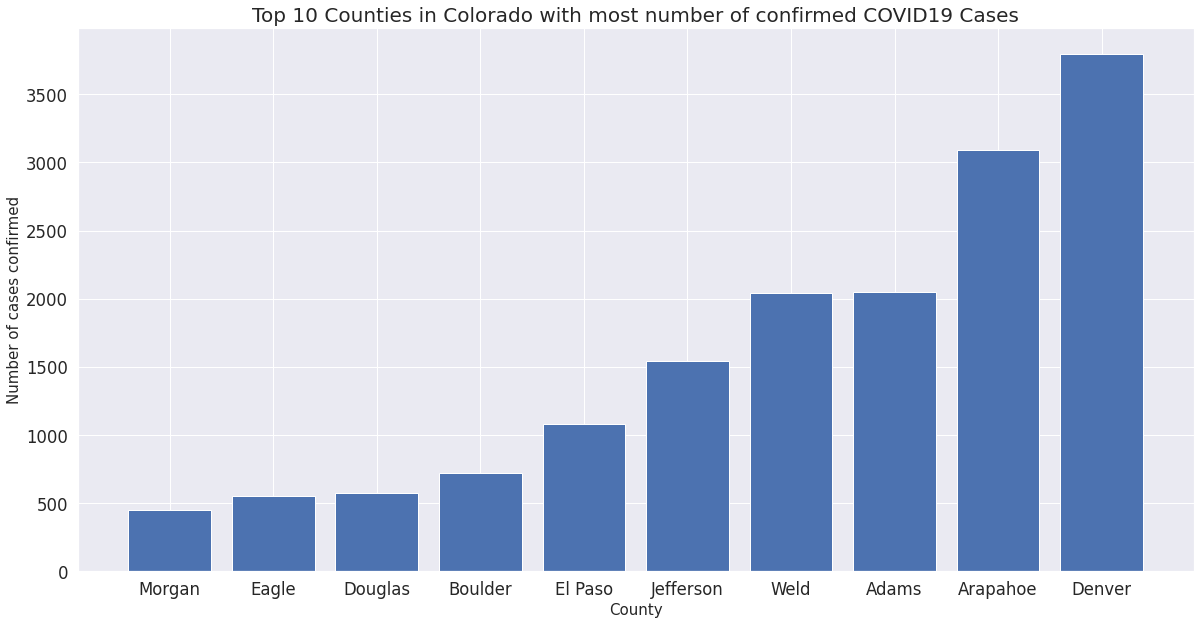

In [77]:
#Top 10 counties with most number of confirmed cases in Colorado
#Denver tops the chart
fig = plt.figure(figsize=(20,10))
plt.bar(result2.sort_values('Confirmed')["Confirmed"].index[-10:],result2.sort_values('Confirmed')["Confirmed"].values[-10:],)
plt.xlabel("County",fontsize=15)
plt.ylabel("Number of cases confirmed",fontsize=15)
plt.title("Top 10 Counties in Colorado with most number of confirmed COVID19 Cases",fontsize=20)

Top 10 counties in colorado with most number of death cases in Colorado

Text(0.5, 1.0, 'Top 10 Counties in Colorado with most number of COVID19 death Cases')

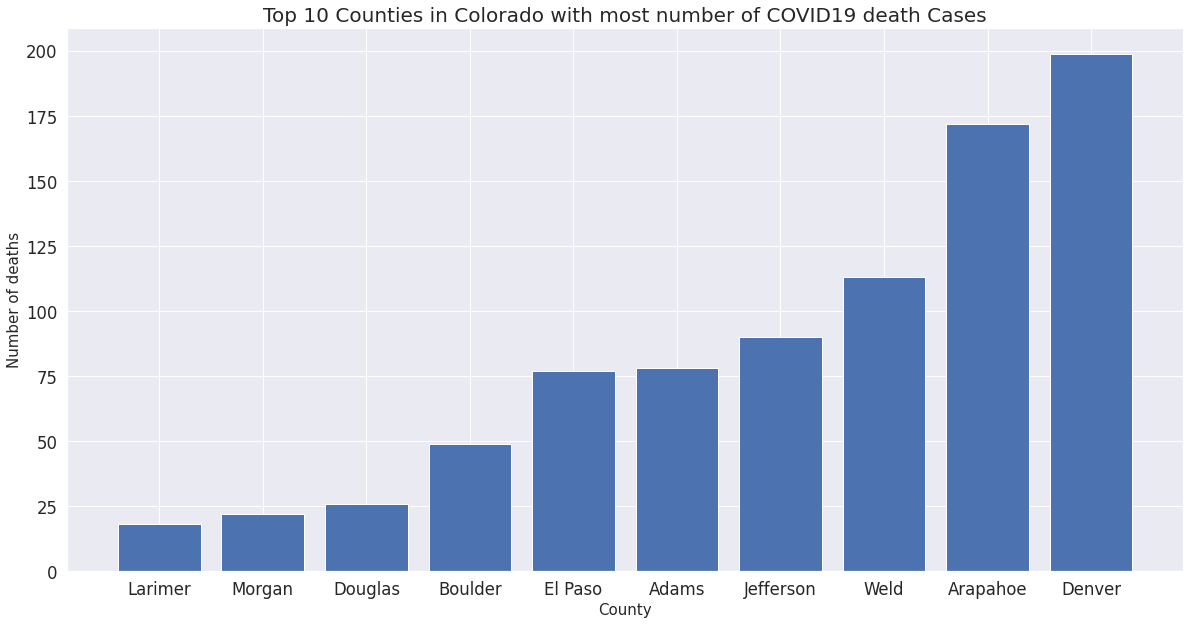

In [78]:
#Top 10 counties in colorado with most number of death cases in Colorado
#Denver tops the chart
fig = plt.figure(figsize=(20,10))
plt.bar(result2.sort_values('Deaths')["Deaths"].index[-10:],result2.sort_values('Deaths')["Deaths"].values[-10:],)
plt.xlabel("County",fontsize=15)
plt.ylabel("Number of deaths",fontsize=15)
plt.title("Top 10 Counties in Colorado with most number of COVID19 death Cases",fontsize=20)

Visualization to know which of the crime was reported the most in April when covid19 cases was in its peak
We can see Public disorder tops the chart.This can occur if the people not maintaining social distancing or for some other reasons

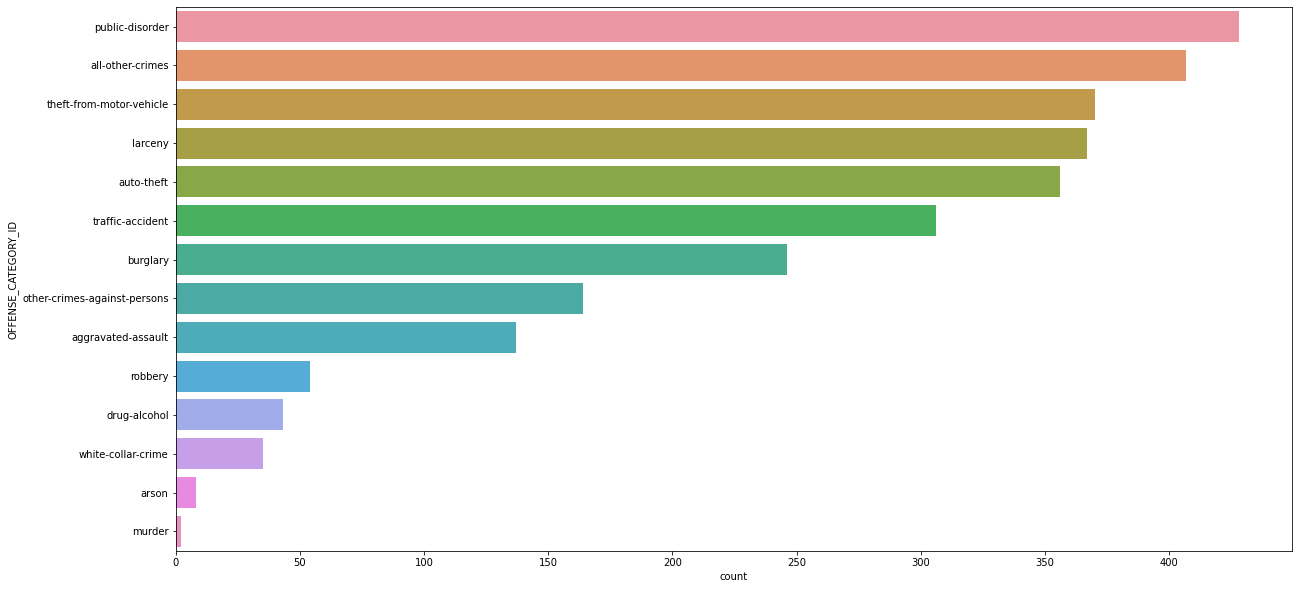

In [22]:
#Visualization to know which of the crime was reported the most in April when covid19 cases was in its peak
#We can see Public disorder tops the chart.This can occur if the people not maintaining social distancing or for some other reasons
plt.figure(figsize=(20,10))
category_frequency1 = data_after_april.OFFENSE_CATEGORY_ID.value_counts()
sns.countplot(y="OFFENSE_CATEGORY_ID", data=data_after_april, order=category_frequency1.index)

This is a visualisation which shows the offense category which was the highest before covid19 hit US
We can see traffic accidents were highest in occurence

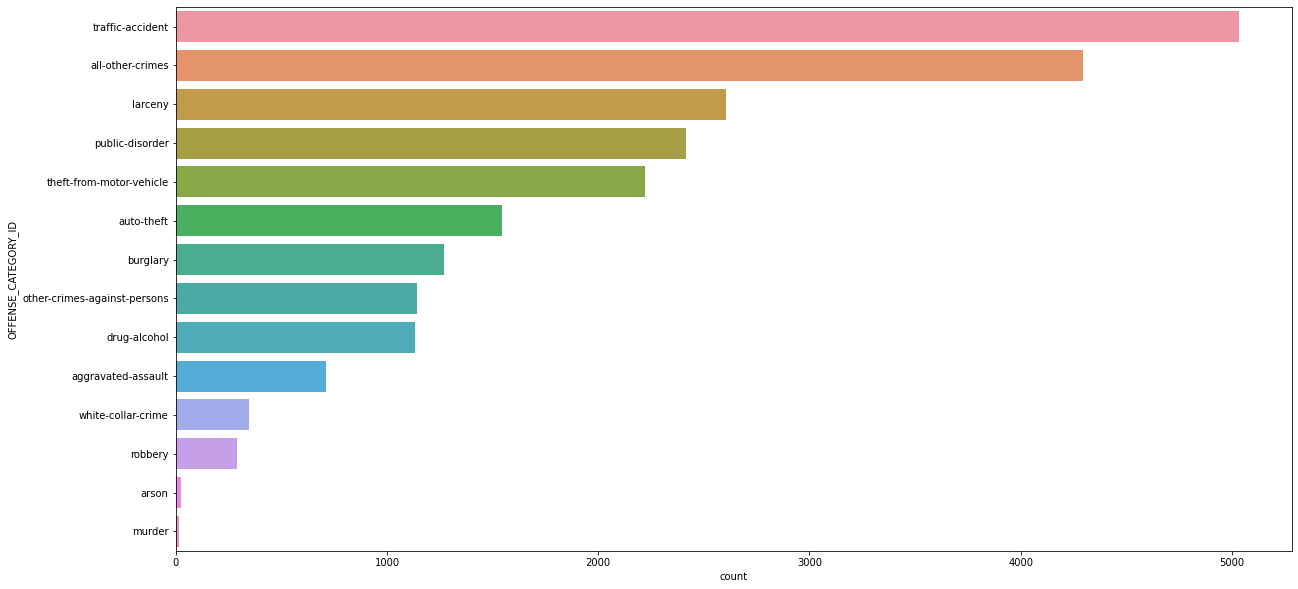

In [23]:
#This is a visualisation which shows the offense category which was the highest before covid19 hit US
#We can see traffic accidents were highest in occurence
plt.figure(figsize=(20,10))
category_frequency = denver_crime.OFFENSE_CATEGORY_ID.value_counts()
sns.countplot(y="OFFENSE_CATEGORY_ID", data=denver_crime, order=category_frequency.index)

In [0]:

is_crime = denver_crime[denver_crime.IS_CRIME==1]
is_traffic = denver_crime[denver_crime.IS_TRAFFIC==1]
is_pd = denver_crime[denver_crime.OFFENSE_CATEGORY_ID=="public-disorder"]


We can see that the over all crime count has decreased significantly over four months after start of covid. But, we see that pulic desorder rate looks to be similar for month 1 and 2, however, it has decreased in month 4

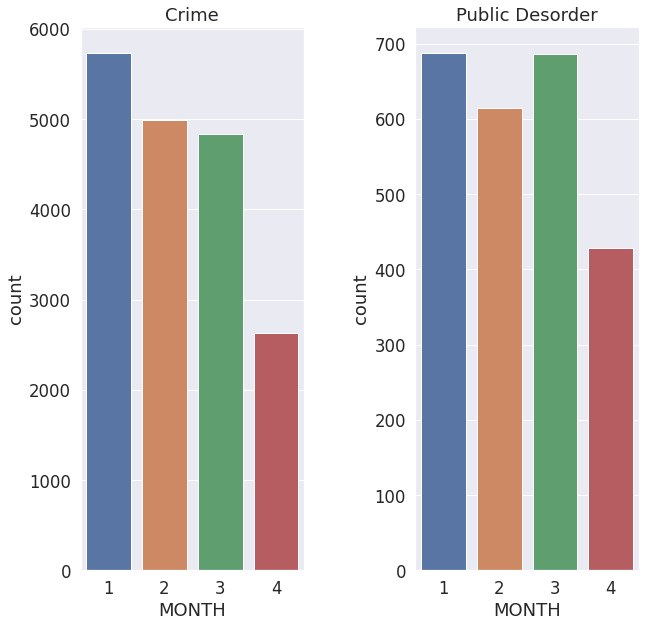

In [85]:
#Total number of crime per month in 2020
x, axes = plt.subplots(1, 2)
x.set_figheight(10)
x.set_figwidth(10)
plt.subplots_adjust(wspace=.5)
axes[0].set_title("Crime")
sns.countplot(x="MONTH", data=is_crime,ax=axes[0])
axes[1].set_title("Public Desorder")
sns.countplot(x="MONTH", data=is_pd,ax=axes[1])

Person correlation for crime data and heatmap

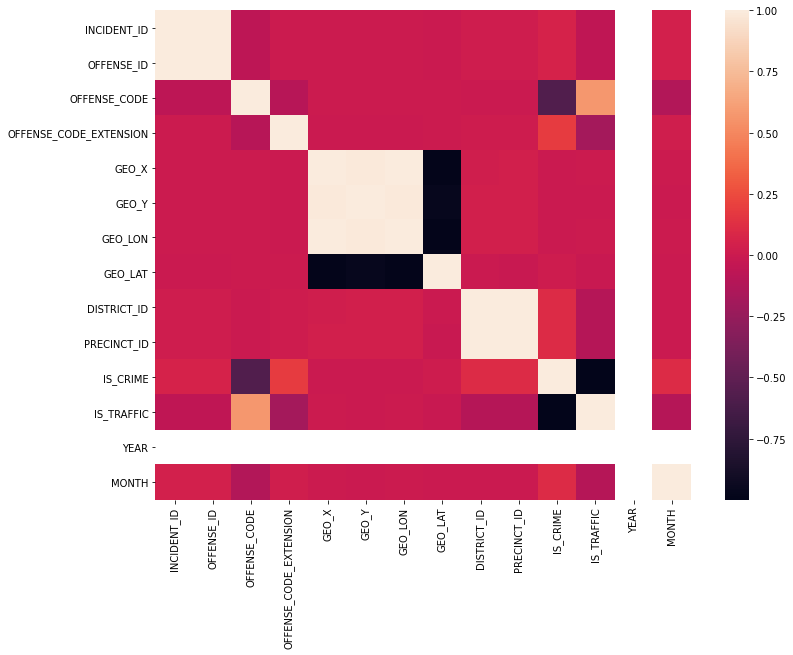

In [28]:
pearsoncorr = denver_crime.corr(method='pearson')
plt.figure(figsize=(12, 9))
sns.heatmap(pearsoncorr)

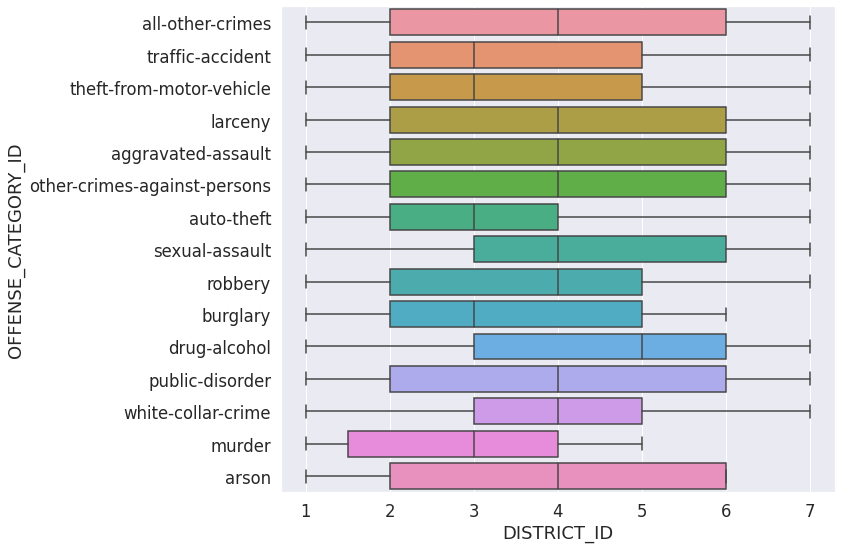

In [89]:
fig = plt.figure(figsize=(20, 15))
sns.set(font_scale=1.5)
fig1 = fig.add_subplot(221); sns.boxplot(x='DISTRICT_ID', y='OFFENSE_CATEGORY_ID', data=denver_crime[['DISTRICT_ID', 'OFFENSE_CATEGORY_ID']])
plt.tight_layout()
plt.show()

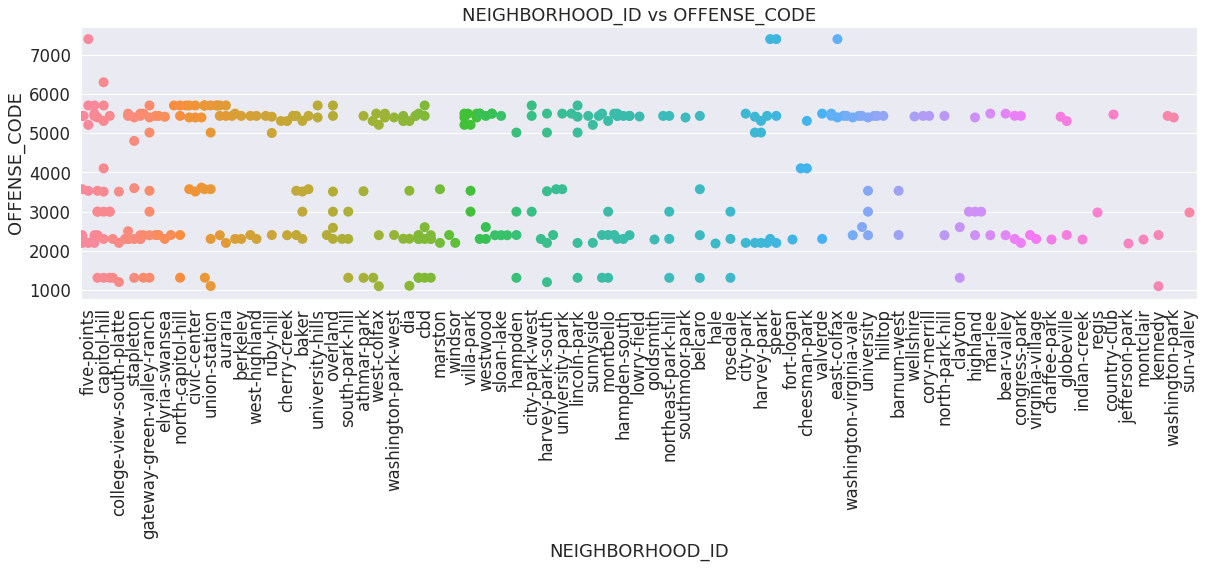

In [90]:
plt.figure(figsize=(20, 5))
sns.swarmplot(x='NEIGHBORHOOD_ID', y='OFFENSE_CODE', data=denver_crime.head(350), size =10)
plt.xticks(rotation=90)
plt.title('NEIGHBORHOOD_ID vs OFFENSE_CODE')
plt.show()

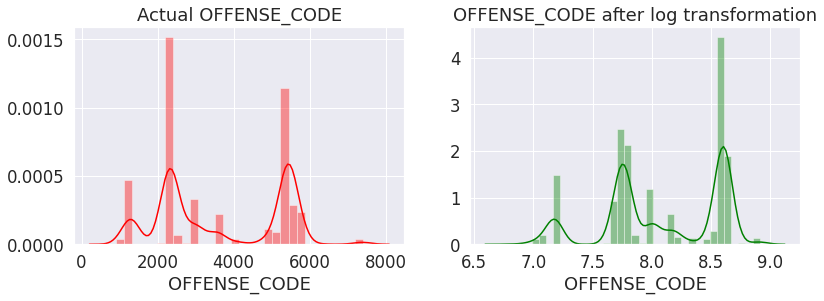

In [91]:
figure = plt.figure(figsize = (13,4))
plt.subplot(1,2,1)
sns.distplot(denver_crime.OFFENSE_CODE, color = 'red')
plt.title('Actual OFFENSE_CODE')
plt.subplot(1,2,2)
sns.distplot(np.log(denver_crime.OFFENSE_CODE), color = 'green')
plt.title('OFFENSE_CODE after log transformation')
plt.show()

In [92]:
########################################################################
############################inference1##################################
#Addition test
colorado_data.drop('Province_State',axis=1,inplace= True)
colorado_data.drop('Country_Region',axis=1,inplace=True)
colorado_data1.drop('Province_State',axis=1,inplace= True)
colorado_data1.drop('Country_Region',axis=1,inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,Date,Confirmed Cases
0,NaN,0
1,1/22/20,0
2,1/23/20,0
3,1/24/20,0
4,1/25/20,0
...,...,...
107,5/7/20,18370
108,5/8/20,18827
109,5/9/20,19375
110,5/10/20,19703


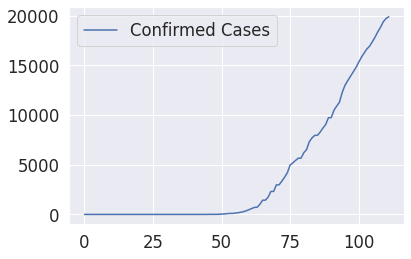

In [93]:
#Total number of cases per day in Colorado(Includes all counties)
df1=colorado_data.sum()
df= df1.T
df=df[1:]
df.to_csv("date_confirmed.csv")
total_df= pd.read_csv("date_confirmed.csv",sep=",",names=['Date','Confirmed Cases'])
total_df.plot()
date_confirmed= total_df
date_confirmed
#change date format




In [94]:
#Total number of death cases per day in Colorado(Includes all counties)
df_2=colorado_data1.sum()
df_3= df_2.T
df_3=df_3[1:]
df_3.to_csv("date_deaths.csv")
total_df_2= pd.read_csv("date_deaths.csv",sep=",",names=['Date','Deaths'])
date_deaths= total_df_2
date_deaths

#change date format





,Date,Deaths
0,NaN,0
1,1/22/20,0
2,1/23/20,0
3,1/24/20,0
4,1/25/20,0
...,...,...
107,5/7/20,944
108,5/8/20,960
109,5/9/20,967
110,5/10/20,971


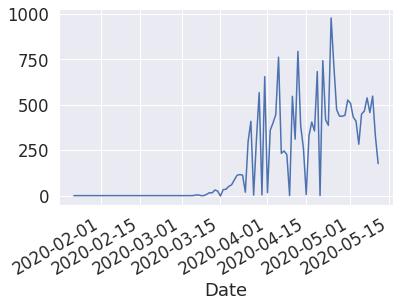

In [95]:
from statsmodels.tsa.seasonal import seasonal_decompose
total_df['Date']=pd.to_datetime(total_df['Date'])
total_df.set_index('Date', inplace=True)
total_df['stationary']=total_df['Confirmed Cases'].diff()
total_df['stationary'].plot()

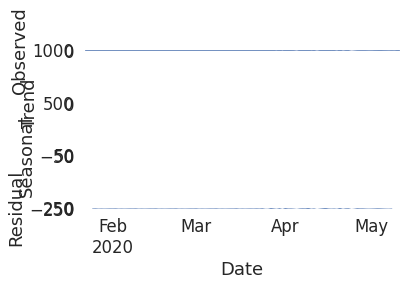

In [37]:
decomposed = seasonal_decompose(total_df['stationary'].dropna(), model='additive')
x =decomposed.plot()

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


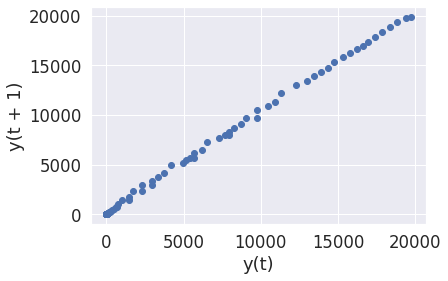

In [96]:
pd.plotting.lag_plot(total_df['Confirmed Cases'])

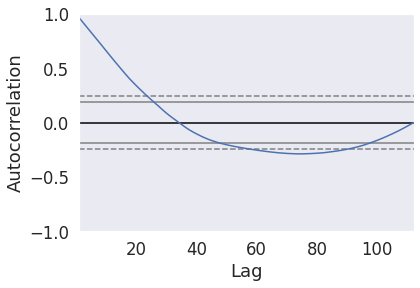

In [97]:
pd.plotting.autocorrelation_plot(total_df['Confirmed Cases'])

In [98]:
tdf=total_df.tail(29)

from statsmodels.tsa.ar_model import AR
from sklearn.metrics import r2_score
X = tdf['stationary'].dropna()

train_data = X[:22]
test_data = X[X[22:]]

len(test_data)

7

In [0]:
#need to calculate MAPE
#MSE
#EWMA CALCULATION
#CHECK HOW TO SET P VALUE FOR AR
#DO AR
#WHAT IS EWMA?

In [99]:
#inference 2
import numpy as np
import math
last2weeks=date_confirmed.tail(14)
seclast_week =last2weeks.head(7)
last_week= last2weeks.tail(7)
X_mean = last_week["Confirmed Cases"].mean(axis=0)
mean_o = seclast_week['Confirmed Cases'].mean(axis=0)
std_dev= date_confirmed["Confirmed Cases"].std(axis=0)
nroot =math.sqrt(len(date_confirmed))
Z= (X_mean - mean_o)/ (std_dev/nroot)
threshold= 1.96

#ONE SAMPLE Z TEST
if(abs(Z)> threshold):
    print("Ho is rejected with absolute value of T  as",abs(Z))
else:
    print("Ho is rejected with absolute value of T  as",abs(Z))

    


Ho is rejected with absolute value of T  as 5.262412465296163


In [100]:
#TWO SAMPLED T TEST

#paired
D=[]
weekSL= seclast_week['Confirmed Cases']. values. tolist()
weekL= last_week['Confirmed Cases']. values. tolist()
for i in range(len(weekSL)):
    D.append(weekL[i]-weekSL[i])
Dmean= (sum(D)/len(D))
T= Dmean/(std_dev/math.sqrt(len(D)))

if(abs(T)> threshold):
    print("Ho is rejected with absolute value of T  as",abs(T))
else:
    print("Ho is rejected with absolute value of T  as",abs(T))


Ho is rejected with absolute value of T  as 1.3156031163240403


In [101]:
# ONE SAMPLE WALD'S TEST
from scipy import stats
theta0 = mean_o
theta_hat = X_mean #Poisson MLE is sample mean
W = (theta_hat-theta0)/np.sqrt(theta_hat/len(last_week))
c = stats.norm().isf(0.05/2)
if(abs(W)> c):
    print("Ho is rejected with absolute value of W as",abs(W))
else:
    print("Ho is accepted with absolute value of W as",abs(W))

Ho is rejected with absolute value of W as 59.11266803721179


In [102]:
# TWO SAMPLED WALD'S TEST

weekSL= seclast_week['Confirmed Cases']. values. tolist()
weekL= last_week['Confirmed Cases']. values. tolist()
# Poisson distribution - MLE is sample mean
X_mean = last_week["Confirmed Cases"].mean(axis=0)
Y_mean = seclast_week['Confirmed Cases'].mean(axis=0)
sX=0
sY=0
for i in range(len(weekSL)):
    sX+= (i-X_mean)**2
    sY+= (i-Y_mean)**2
sX= sX/len(weekL)
sY= sY/len(weekSL)
denom= math.sqrt((sX/len(weekL))+(sY/len(weekSL)))
W = ((X_mean-Y_mean)/(denom))
if(abs(W)> c):
    print("Ho is rejected with absolute value of W as",abs(W))
else:
    print("Ho is accepted with absolute value of W as",abs(W))

Ho is accepted with absolute value of W as 0.33098580581133785


***********************************INFERENCE 3********************************

KS test and Permutation test. We are considering data from last week and second last week (new cases/day)

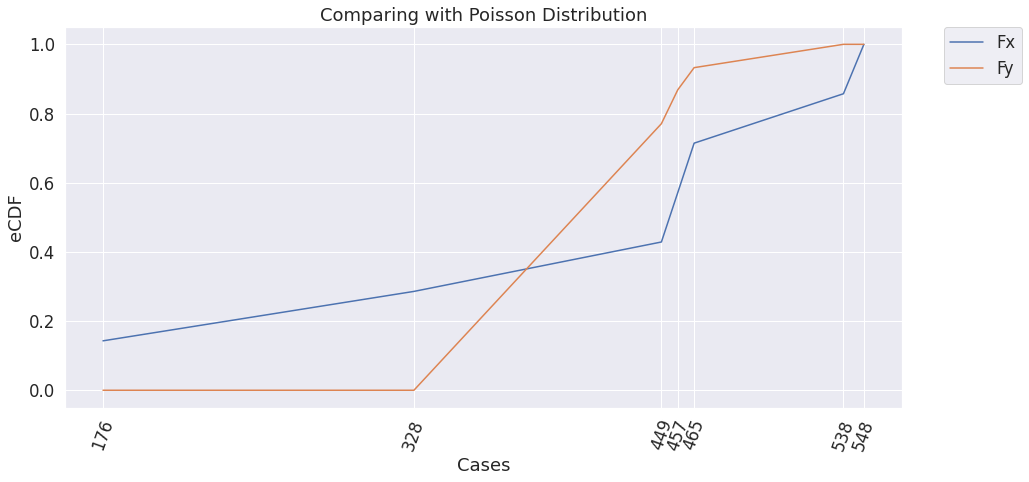

       x            Fy       Fx-       Fx+        Fy-Fx-        Fy-Fx+
0  176.0  4.033573e-45  0.000000  0.142857  4.033573e-45  1.428571e-01
1  328.0  6.061657e-08  0.142857  0.285714  1.428571e-01  2.857142e-01
2  449.0  7.705676e-01  0.285714  0.428571  4.848533e-01  3.419961e-01
3  457.0  8.684496e-01  0.428571  0.571429  4.398782e-01  2.970210e-01
4  465.0  9.325766e-01  0.571429  0.714286  3.611480e-01  2.182908e-01
5  538.0  9.999993e-01  0.714286  0.857143  2.857136e-01  1.428565e-01
6  548.0  9.999999e-01  0.857143  1.000000  1.428571e-01  6.519774e-08
Ho is rejected as D is  0.48485326582973787  (given C = 0.05)


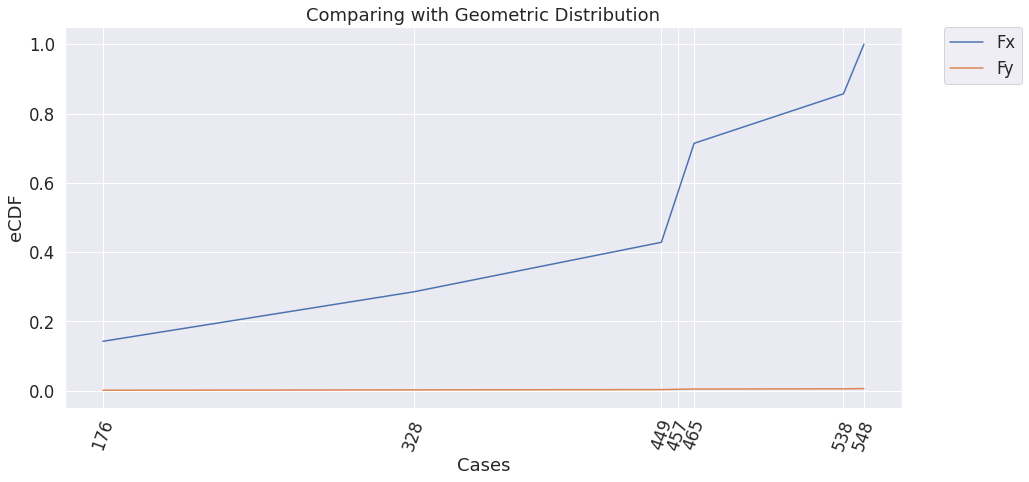

       x        Fy       Fx-       Fx+    Fy-Fx-    Fy-Fx+
0  176.0  0.001539  0.000000  0.142857  0.001539  0.141319
1  328.0  0.002622  0.142857  0.285714  0.140235  0.283092
2  449.0  0.003442  0.285714  0.428571  0.282272  0.425130
3  457.0  0.004247  0.428571  0.571429  0.424325  0.567182
4  465.0  0.005037  0.571429  0.714286  0.566392  0.709249
5  538.0  0.005704  0.714286  0.857143  0.708581  0.851438
6  548.0  0.006357  0.857143  1.000000  0.850786  0.993643
Ho is rejected as D is  0.9936431044031026  (given C = 0.05)
434.14285714285717 5363.265306122449
n=  -38.238047920108315 p=  -11.353687773233675
looking at estomated n and p values we can clearly see that this data would not be a good fit for binomial


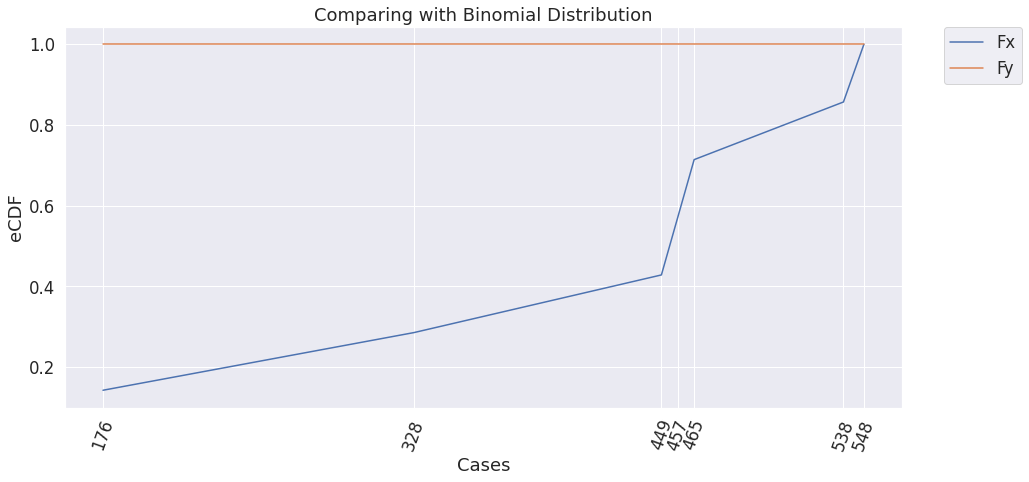

       x   Fy       Fx-       Fx+    Fy-Fx-    Fy-Fx+
0  176.0  1.0  0.000000  0.142857  1.000000  0.857143
1  328.0  1.0  0.142857  0.285714  0.857143  0.714286
2  449.0  1.0  0.285714  0.428571  0.714286  0.571429
3  457.0  1.0  0.428571  0.571429  0.571429  0.428571
4  465.0  1.0  0.571429  0.714286  0.428571  0.285714
5  538.0  1.0  0.714286  0.857143  0.285714  0.142857
6  548.0  1.0  0.857143  1.000000  0.142857  0.000000
Ho is rejected as D is  1.0  (given C = 0.05)


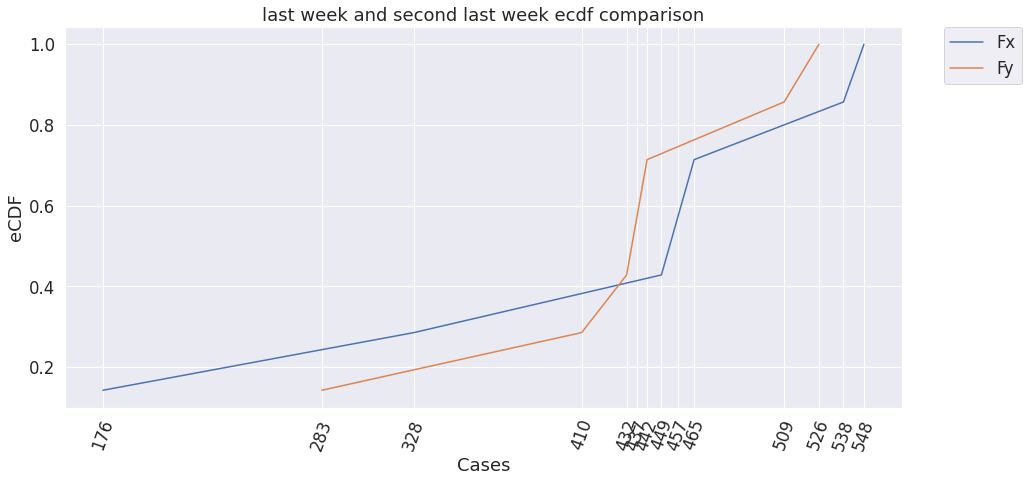

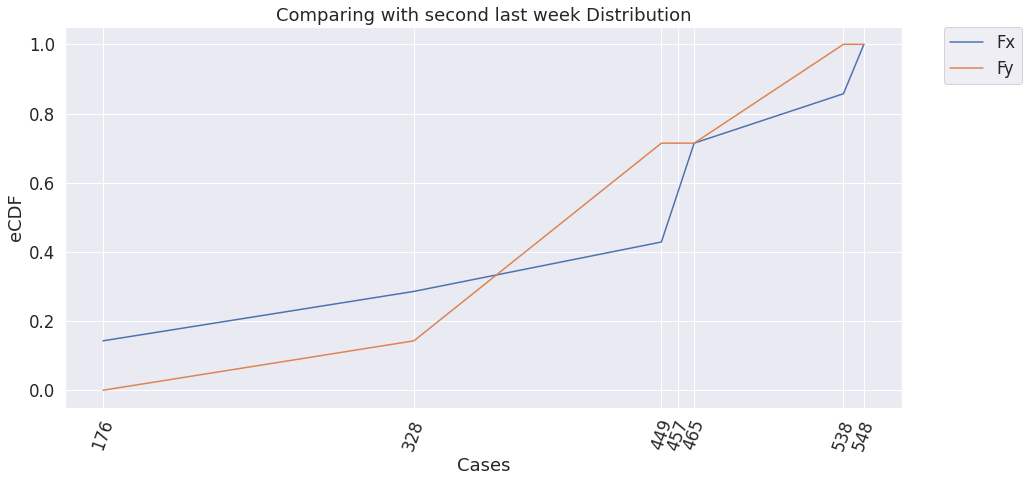

       x        Fy       Fx-       Fx+    Fy-Fx-    Fy-Fx+
0  176.0  0.000000  0.000000  0.142857  0.000000  0.142857
1  328.0  0.142857  0.142857  0.285714  0.000000  0.142857
2  449.0  0.714286  0.285714  0.428571  0.428571  0.285714
3  457.0  0.714286  0.428571  0.571429  0.285714  0.142857
4  465.0  0.714286  0.571429  0.714286  0.142857  0.000000
5  538.0  1.000000  0.714286  0.857143  0.285714  0.142857
6  548.0  1.000000  0.857143  1.000000  0.142857  0.000000
Ho is rejected as D is  0.4285714285714286  (given C = 0.05)
****** Please scroll up to see all graphs and analysis of KS test ******


In [103]:
##############################################INFERENCE3(KS TEST and PERMUTATION TEST)########################
#K-S test 
import numpy as np
import math
from scipy.stats import poisson
from scipy.stats import geom
from scipy.stats import binom

# function to plot two samples according to distribution 
def plotvalues(Fy, y, Fx, x, title, xvals):
  plt.figure(figsize=(15,7))
  sns.set(font_scale=1.5)
  plt.tight_layout()
  plt.plot(x, Fx, label="Fx")
  plt.plot(y, Fy, label="Fy")
  plt.xlabel('Cases')
  plt.ylabel('eCDF')
  plt.xticks(xvals, rotation="70")
  plt.title(title)
  plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
  plt.show()
  

# Function to compute K-S statistic and accept/reject hypothesis bases on statistics
def kstest(Fy, last_week_confirmed, C, title):

  Fx = [0]

  for i in last_week_confirmed:
    cdf = len([k for k in last_week_confirmed if k <= i]) / len(last_week_confirmed)
    Fx.append(cdf)

  plotvalues(Fy, last_week_confirmed,  Fx[1:], last_week_confirmed, title, last_week_confirmed)

  ks_df = pd.DataFrame()
  ks_df["x"] = last_week_confirmed
  ks_df["Fy"] = Fy
  ks_df["Fx-"] = Fx[:-1]
  ks_df["Fx+"] = Fx[1:]
  ks_df["Fy-Fx-"] = abs(ks_df["Fy"] - ks_df["Fx-"])
  ks_df["Fy-Fx+"] = abs(ks_df["Fy"] - ks_df["Fx+"])
  print(ks_df)

  D = max(ks_df["Fy-Fx-"].max(),ks_df["Fy-Fx+"].max())

  if D > C:
    print("Ho is rejected as D is ", D, " (given C = 0.05)")
  else:
    print("Ho is accepted as D is ", D, " (given C = 0.05)")

def cdf_calc(fx):
  Fx = [fx[0]]
  for i in range(1, len(fx)):
    Fx.append(fx[i]+Fx[i-1])
  return Fx

#Poisson cdf function 

def poisson_cdf(last_week_confirmed, pois_lambda):
  # fx = []
  # for i in last_week_confirmed:
  #   num1 = math.pow(pois_lambda,x)
  #   num2 = (math.exp(-pois_lambda))
  #   num = num1 * num2
  #   denom = math.factorial(x)
  #   fx.append(num/denom)

  # cdf = cdf_calc(fx)
  # return cdf
  Fx = []

  for i in last_week_confirmed:
    Fx.append(poisson.cdf(i, pois_lambda))
  return Fx

# geometric cdf function
def geom_cdf(last_week_confirmed, p):
  fx = []
  for i in last_week_confirmed:
    val = ((1-p)**(i-1)) * p
    fx.append(val)
  Fx = cdf_calc(fx)
  return Fx

# binomial cdf function 
def binom_cdf(last_week_confirmed, n, p):
  Fx = []

  for i in last_week_confirmed:
    Fx.append(binom.cdf(i, n, p))
  return Fx

last2weeks=date_confirmed.tail(14)
seclast_week =last2weeks.head(7)
last_week= last2weeks.tail(7)

seclast_week_confirmed = sorted(seclast_week['stationary'])
last_week_confirmed = sorted(last_week['stationary'])
C = 0.05

# 1-sample

# calculating MME of second last week and calculating cdfs 

sample_mean = np.mean(np.array(seclast_week['stationary']))

# poisson MME
pois_lambda = sample_mean
Fx_poisson = poisson_cdf(last_week_confirmed, pois_lambda)
kstest(Fx_poisson, last_week_confirmed, C, 'Comparing with Poisson Distribution')

# Geometric MME
p = 1/sample_mean
Fx_geometric = geom_cdf(last_week_confirmed, p)
kstest(Fx_geometric, last_week_confirmed, C, 'Comparing with Geometric Distribution')

# Binomial MME
sample_variance = np.var(np.array(seclast_week['stationary']))
print(sample_mean, sample_variance)
n = sample_mean**2 / (sample_mean-sample_variance)
p = sample_mean / n
print("n= ", n, "p= ", p)

print("looking at estimated n and p values we can clearly see that this data would not be a good fit for binomial")

Fx_binomial = binom_cdf(last_week_confirmed, n, p)
kstest(Fx_binomial, last_week_confirmed, C, 'Comparing with Binomial Distribution')

# 2-samples K-S test 

Fx_seclast_week = []
for i in seclast_week_confirmed:
  cdf = len([k for k in seclast_week_confirmed if k <= i]) / len(seclast_week_confirmed)
  Fx_seclast_week.append(cdf)

Fx_last_week = []
for i in last_week_confirmed:
  cdf = len([k for k in last_week_confirmed if k <= i]) / len(last_week_confirmed)
  Fx_last_week.append(cdf)

xvalues = []
xvalues.extend(last_week_confirmed)
xvalues.extend(seclast_week_confirmed)
xvalues.sort()
plotvalues(Fx_seclast_week, seclast_week_confirmed,  Fx_last_week, last_week_confirmed, "last week and second last week ecdf comparison", xvalues)

Fy_two_sample = []
for i in last_week_confirmed:
  cdf = len([k for k in seclast_week_confirmed if k <= i]) / len(seclast_week_confirmed)
  Fy_two_sample.append(cdf)
kstest(Fy_two_sample, last_week_confirmed, C, 'Comparing with second last week Distribution')


print("****** Please scroll up to see all graphs and analysis of KS test ******")

Ho is rejected by 1-sample test (poisson, geometric, binomial) as well as 2- sample test at critical value 0.05. But, if we see the graphs and D value, we can see that geometric and binomial distributions do not fit this data at all. Whereas, we can poisson being a nearest distribution for this data among the three. We can also see that distribution for last to last week and last week is also pretty different 

Below is the permutation test. We are considering new case data from second last week (new cases/day) and last week (new cases/day). 

In [104]:
# Permutation test 

import random

def mean(x):
  return sum(x)/len(x)

# function to calculate p value and accept/reject hypothesis 
def perm_test(n, list1, list2, alpha):
  Tobs = abs(mean(list1) - mean(list2))

  all_data = []
  all_data.extend(list1)
  all_data.extend(list2)

  result = []

  for i in range(n):
    permute = random.shuffle(all_data)
    temp_list1 = all_data[:len(list1)]
    temp_list2 = all_data[-len(list1):]
    Ti = abs(mean(temp_list1) - mean(temp_list2))
    if Ti > Tobs:
      result.append(1)
    else:
      result.append(0)

  p_value = sum(result) / n

  if p_value <= alpha: 
    print("Ho is rejected as p-value is ", p_value, " (given alpha = 0.05)")
  else:
    print("Ho is accepted as p-value is ", p_value, " (given alpha = 0.05)")

seclast_week_data = list(seclast_week['stationary'])
last_week_data = list(last_week['stationary'])
alpha = 0.05 

perm_test(100000, seclast_week_data, last_week_data, alpha)

Ho is accepted as p-value is  0.84747  (given alpha = 0.05)


We can see that the hypothesis is accepted by permutation test. This implies that data from second last week ad last week are similar in terms of number of cases 

***********************************INFERENCE 4 ********************************

Pearson's correlation. We are considering data from 5th March to 5th April both covid data and crime data 

In [0]:
#########################################INFERRENCE4(CONFIRMED CASES)##################################################
#####################################################################################################
#Month under consideration for calculating pearson's correlation
#Obtaining the month's data from COVID dataset - 5th March to 5th April
month_under_consideration_test=date_confirmed.tail(66)
month_test=month_under_consideration_test.head(32)


In [0]:
#Obtaining month's data from denver crime dataset

data_after_april_test['Date'] = data_after_april_test['FIRST_OCCURRENCE_DATE'].dt.date

data_after_april_test = data_after_april_test.sort_values(by="Date")
final_inference_data_test = data_after_april_test[['OFFENSE_CATEGORY_ID','Date','IS_CRIME','IS_TRAFFIC']]
final_inference_data1_test = final_inference_data_test.loc[final_inference_data_test['OFFENSE_CATEGORY_ID'] == 'traffic-accident']
group_test1 = final_inference_data1_test.groupby('Date')

df_final = group_test1.sum()
df_final1 = df_final.head(36)
df_final2 = df_final1.tail(32)
merged_df = pd.concat([month_test,df_final2], axis=1)
date_deaths1 = date_deaths.copy()
date_deaths2 = date_deaths1.set_index('Date', inplace=True)


Preparing data for inference 4

In [106]:
##################################################INFERRENCE4(DEATHCASES)###################################################
#############################################################################################################################
#Month under consideration for calculating pearson's correlation
#Obtaining the month's data from COVID dataset - 5th March to 5th April
month_under_consideration_deaths_test=date_deaths.tail(66)
month_deaths_test=month_under_consideration_deaths_test.head(32)
month_deaths_test['Date']=pd.to_datetime(month_deaths_test['Date'])
month_deaths_test.set_index('Date', inplace=True)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [108]:
##########################################Inference4 Pearson's coefficient####################################
#########################################Impact of denver's covid 19 cases on Denver Crime###########################

#Obtaining just the denver data
denver_data = data.loc[data['Admin2'] == 'Denver']
#######################DENVER CONFIRMED CASES##################################
df1_denver=denver_data.sum()
df_denver= df1_denver.T
df_denver=df_denver[1:]
df_denver.to_csv("date_confirmed_denver.csv")
total_df_denver= pd.read_csv("date_confirmed_denver.csv",sep=",",names=['Date','Confirmed Cases'])
date_confirmed_denver= total_df

#change date format
#One months data (5th march to 5th April) before and after the lockdown was imposed
month_under_consideration_denver_test=date_confirmed_denver.tail(66)
month_confirmed_test_denver=month_under_consideration_denver_test.head(32)

#Table which has the number of confirmed cases per day and number of traffic and crime cases per day(In one month's duration)
merged_confirmed_df_denver = pd.concat([month_confirmed_test_denver,df_final2], axis=1)
merged_confirmed_df_denver


,Confirmed Cases,stationary,IS_CRIME,IS_TRAFFIC
Date,,,,
2020-03-05,NaN,NaN,0.0,71.0
2020-03-06,NaN,NaN,0.0,66.0
2020-03-07,7.0,4.0,0.0,43.0
2020-03-08,7.0,0.0,0.0,45.0
2020-03-09,7.0,0.0,0.0,50.0
2020-03-10,14.0,7.0,0.0,40.0
2020-03-11,30.0,16.0,0.0,49.0
2020-03-12,45.0,15.0,0.0,44.0
2020-03-13,76.0,31.0,0.0,43.0


In [109]:
######################DENVER DEATH CORRELATION#####################
#Addition test
df_2_denver=colorado_data1.sum()
df_3_denver= df_2_denver.T
df_3_denver=df_3_denver[1:]
df_3_denver.to_csv("date_deaths_denver.csv")
total_df_2_denver= pd.read_csv("date_deaths_denver.csv",sep=",",names=['Date','Deaths'])
date_deaths_denver= total_df_2_denver

date_deaths1_denver = date_deaths_denver.copy()
date_deaths2_denver = date_deaths1_denver.set_index('Date', inplace=True)

date_deaths1_denver = date_deaths_denver.copy()
date_deaths2_denver = date_deaths1_denver.set_index('Date', inplace=True)

month_under_consideration_denver_deaths_test=date_deaths_denver.tail(66)
month_deaths_test_denver=month_under_consideration_denver_deaths_test.head(32)

month_deaths_test_denver['Date']=pd.to_datetime(month_deaths_test_denver['Date'])
month_deaths_test_denver.set_index('Date', inplace=True)

#Merged data for denver
merged_deaths_df_denver = pd.concat([month_deaths_test_denver,df_final2], axis=1)
merged_deaths_df_denver
#change date format

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Deaths,IS_CRIME,IS_TRAFFIC
Date,,,
2020-03-05,NaN,0.0,71.0
2020-03-06,NaN,0.0,66.0
2020-03-07,0.0,0.0,43.0
2020-03-08,0.0,0.0,45.0
2020-03-09,0.0,0.0,50.0
2020-03-10,0.0,0.0,40.0
2020-03-11,0.0,0.0,49.0
2020-03-12,0.0,0.0,44.0
2020-03-13,1.0,0.0,43.0


Calculating Pearson's correlation for confirmed cases

In [110]:
#Pearson's correlation coeeficient by using formula
#IMPACT OF COVID19 CASES ON TRAFFIC ACCIDENT(CONFIRMED CASES)
#NEGATIVE CORRELATION IMPLIES WHEN NUMBER OF CASES INCREASED TRAFFIC ACCIDENTS DECREASED

column_5 = merged_confirmed_df_denver["Confirmed Cases"]
column_6 = merged_confirmed_df_denver["IS_TRAFFIC"]
covariance_confirmed_denver = column_5.cov(column_6)
std_dev_cases_confirmed_denver= merged_confirmed_df_denver["Confirmed Cases"].std(axis=0)
std_dev_crime_confirmed_denver= merged_confirmed_df_denver["IS_TRAFFIC"].std(axis=0)
corr_confirmed_denver = covariance_confirmed_denver/(std_dev_crime_confirmed_denver*std_dev_cases_confirmed_denver)
print(corr_confirmed_denver)

-0.4192225218698202


We see a negative correlation but is less than 0.5. We can conclude that this does not have a very strong correlation but we can say it is somewhat negatively correlated. This means, while number of confirmed cases increased, Traffic accidents decreased

Calculating Pearson's correlation for death cases

In [111]:
#Pearson's correlation coeeficient by using formula
#CORRELATION BTW COVID19 DEATH CASES AND TRAFFIC ACCIDENTS
#NEGATIVE VALUE INDICATES NEGATIVE CORRELATION BTW THEM
column_7 = merged_deaths_df_denver["Deaths"]
column_8 = merged_deaths_df_denver["IS_TRAFFIC"]
covariance_deaths_denver = column_7.cov(column_8)
std_dev_cases_deaths_denver= merged_deaths_df_denver["Deaths"].std(axis=0)
std_dev_crime_deaths_denver= merged_deaths_df_denver["IS_TRAFFIC"].std(axis=0)
corr_deaths_de = covariance_deaths_denver/(std_dev_crime_deaths_denver*std_dev_cases_deaths_denver)
print(corr_deaths_de)

-0.3295333236196537


We see a negative correlation but is less than 0.5. We can conclude that this does not have a very strong correlation but we can say it is somewhat negatively correlated. This means, while number of deaths increased, Traffic accidents decreased

This correlation seems to be caused by the stay at home orders or lockdown orders imposed due to covid spread

### Inference 5 - Bayesian Inferences 
Here, the assumption is that the data is of poisson distribution. In the given scenario(Poisson distributed likelihood data and an exponential prior), we can assume a gamma conjugate prior and thus a gamma distribution for prior will be helpful in finding  in the posterior for each week of COVID death related data. 

In [2]:
from scipy.stats import gamma
covid_death_bayesian_data = month_deaths_test 
# extracting the data for the death cases for Colorado 
inf5_data = covid_death_bayesian_data['Deaths'] 
# splitting the array so that we have weekly data present
inf5_data_split = np.split(inf5_data, 4)

NameError: name 'month_deaths_test' is not defined

In [ ]:
* Prior is gamma
* Likelihood is poisson's distribution with parameter lambda 
* The posterior will be a gamma with parameters alpha + summation(sample) and beta + length of sample 

In [1]:
# This function is for plotting the posterior obtained after each round 
def show_distr(result_arr):
    for i in range(0, result_arr.shape[0]):
        x = np.linspace(gamma.ppf(0.01, result_arr[i][0], scale=1 / result_arr[i][1]),
                        gamma.ppf(0.99, result_arr[i][0], scale=1 / result_arr[i][1]), 1000)

        plt.plot(gamma.pdf(x, a=result_arr[i][0], scale=1 / result_arr[i][1]))
    plt.xlabel('Deaths')
    plt.ylabel('pdf of lamda')
    plt.gca().legend(('1st Round', '2nd Round', '3rd Round', '4th Round'))
    plt.show()
    return

In [ ]:
# The following code is for finding the parameters for the posterior after each round 
# Using the hint provided in the question to find the beta value 
beta = len(inf5_data_split[0]) / (np.mean(inf5_data_split[0])) # MME of lambda using first week's data 
prior_beta = 1 / beta
prior_alpha = 1
result = np.zeros((4, 2))
for i in range(len(result)):
    sigma_xi = 0
    for j in range(len(inf5_data_split[0])):
        sigma_xi = sigma_xi + inf5_data_split[i][j]
    prior_alpha = prior_alpha + sigma_xi
    prior_beta = len(inf5_data_split[0]) + prior_beta
    result[i][0] = prior_alpha
    result[i][1] = prior_beta
    lambda_mean = (prior_alpha) / (prior_beta)
show_distr(result)

Based on the above results we can see that after 4 rounds, the MAP estimates are as follows : 
### Round 1: 180 deaths  
### Round 2: 400 deaths
### Round 3: 480 deaths
### Round 4: 500 deaths

This result is expected because we have taken a time period when Covid was rising through the Colorado counties. Also, we can see that the results start becoming more stable and graph shifts towards the center with more rounds(more data).

In [0]:
# Creative - 1

In [0]:
# Linear Regression Relationship between Number of Deaths due to COVID-19 and the crime rate (non-traffic) in Colorado
# from Feb,2020 till Apr, 2020

In [0]:
data_after_feb = denver_crime.copy()
data_after_feb = data_after_feb[data_after_feb.MONTH != 1]
data_after_feb["Date"] = denver_crime.FIRST_OCCURRENCE_DATE.dt.date
data = data_after_feb.loc[data_after_feb['IS_CRIME'] == 1]

In [0]:
data1 = data.groupby('Date')
data2 = data1.sum()
data2 = data2.filter(['Date', 'IS_CRIME'])
data2 = data2.set_index(pd.to_datetime(data2.index))

In [0]:
colo = colorado_data1
colo

,Admin2,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,...,5/2/20,5/3/20,5/4/20,5/5/20,5/6/20,5/7/20,5/8/20,5/9/20,5/10/20,5/11/20
249,Adams,0,0,0,0,0,0,0,0,0,...,68,68,68,72,75,78,80,81,81,81
250,Alamosa,0,0,0,0,0,0,0,0,0,...,2,2,2,2,2,2,2,2,2,2
251,Arapahoe,0,0,0,0,0,0,0,0,0,...,153,156,157,165,167,172,177,176,176,179
252,Archuleta,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
253,Baca,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
310,Washington,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
311,Weld,0,0,0,0,0,0,0,0,0,...,100,100,102,107,109,113,113,113,113,114
312,Yuma,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3154,Out of CO,0,0,0,0,0,0,0,0,0,...,2,2,2,2,2,2,2,2,2,1


In [0]:
#del colo['Admin2']
#del colo['Province_State']
#del colo['Country_Region']
#del colo['Population']
colo = colo.T
colo.index.names = ['Date']
colo['Sum'] = colo.sum(axis=1)

In [0]:
colo

,249,250,251,252,253,254,255,256,257,258,...,306,307,308,309,310,311,312,3154,3206,Sum
Date,,,,,,,,,,,,,,,,,,,,,
Admin2,Adams,Alamosa,Arapahoe,Archuleta,Baca,Bent,Boulder,Broomfield,Chaffee,Cheyenne,...,San Miguel,Sedgwick,Summit,Teller,Washington,Weld,Yuma,Out of CO,Unassigned,AdamsAlamosaArapahoeArchuletaBacaBentBoulderBr...
1/22/20,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1/23/20,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1/24/20,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1/25/20,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5/7/20,78,2,172,0,0,0,49,16,16,0,...,0,0,1,2,0,113,0,2,3,944
5/8/20,80,2,177,0,0,0,50,16,16,0,...,0,0,1,2,0,113,0,2,3,960
5/9/20,81,2,176,0,0,0,50,17,16,0,...,0,0,1,2,0,113,0,2,3,967


In [0]:
colo1 = pd.DataFrame()
#colo1['Date']=colo.index
colo1['Number Of Deaths']=colo['Sum']
colo1 = colo1.set_index(pd.to_datetime(colo1.index))
df = data2.merge(colo1, how='inner', right_index=True, left_index=False, on='Date')

ParserError: Unknown string format: Admin2

In [0]:
# Linear Regression between the crime rate and COVID-19 period

def estimate_coef(x, y): 
    # number of observations/points 
    n = np.size(x) 
  
    # mean of x and y vector 
    m_x, m_y = np.mean(x), np.mean(y) 
  
    # calculating cross-deviation and deviation about x 
    SS_xy = np.sum(y*x) - n*m_y*m_x 
    SS_xx = np.sum(x*x) - n*m_x*m_x 
  
    # calculating regression coefficients 
    b_1 = SS_xy / SS_xx 
    b_0 = m_y - b_1*m_x 
  
    return(b_0, b_1) 
  
def plot_regression(x, y, b): 
    # plotting the actual points as scatter plot 
    plt.scatter(x, y, color = "m", 
               marker = "o", s = 30) 
  
    # predicted response vector 
    y_pred = b[0] + b[1]*x 
  
    # plotting the regression line 
    plt.plot(x, y_pred, color = "g") 
  
    # putting labels 
    plt.xlabel('Number of Deaths') 
    plt.ylabel('IS_CRIME') 
  
    # function to show plot 
    plt.show() 
  
def main(): 
    # observations 
    x = df['Number Of Deaths'] 
    y = df['IS_CRIME'] 
  
    # estimating coefficients 
    b = estimate_coef(x, y) 
    print("Estimated coefficients:\n b_0 = {}  \n b_1 = {}".format(b[0], b[1])) 
  
    # plotting regression line 
    plot_regression(x, y, b) 
  
if __name__ == "__main__": 
    main() 

KeyError: 'Number Of Deaths'

In [0]:
# From above, it can be clearly seen that crime rate decreases during the lockdown period of COVID-19.

In [0]:
# Creative - 2
# Chi-square test to understand the impact of COVID-19 on crime rate
# H0 = Crime rate is dependent on COVID-19
# H1 = Crime rate is independent of COVID-19

In [0]:
# After COVID-19 outbreak
d1 = data_after_april.loc[data_after_april['IS_TRAFFIC'] == 1]
data_after_april["Date"] = denver_crime.FIRST_OCCURRENCE_DATE.dt.date
dt1 = d1.groupby('Date')
dt2 = dt1.sum()
dt3 = dt2.filter(['Date', 'IS_TRAFFIC'])
dt3 = dt3.set_index(pd.to_datetime(dt3.index))
dt3.loc['Column_Total']= dt3.sum(numeric_only=True, axis=0)

KeyError: 'Date'

In [0]:
d1 = data_after_april.loc[data_after_april['IS_CRIME'] == 1]
#data_after_april["Date"] = denver_crime.FIRST_OCCURRENCE_DATE.dt.date
dt1 = d1.groupby('Date')
dt2 = dt1.sum()
dt3 = dt2.filter(['Date', 'IS_CRIME'])
dt3 = dt3.set_index(pd.to_datetime(dt3.index))
dt3.loc['Column_Total']= dt3.sum(numeric_only=True, axis=0)

In [0]:
# Before COVID-19 outbreak
data_jan = denver_crime.copy()
data_jan = data_jan[data_jan.MONTH == 1]
data_jan["Date"] = denver_crime.FIRST_OCCURRENCE_DATE.dt.date
dit1 = data_jan.loc[data_jan['IS_TRAFFIC'] == 1]
dit1 = dit1.groupby('Date')
dit2 = dit1.sum()
dit3 = dit2.filter(['Date', 'IS_TRAFFIC'])
dit3 = dit3.set_index(pd.to_datetime(dit3.index))
dit3.loc['Column_Total']= dit3.sum(numeric_only=True, axis=0)

In [0]:
d2 = data_jan.loc[data_jan['IS_CRIME'] == 1]
#data_jan["Date"] = denver_crime.FIRST_OCCURRENCE_DATE.dt.date
d2_1 = d1.groupby('Date')
d2_2 = d2_1.sum()
d2_3 = d2_2.filter(['Date', 'IS_CRIME'])
d2_3 = d2_3.set_index(pd.to_datetime(d2_3.index))
d2_3.loc['Column_Total']= d2_3.sum(numeric_only=True, axis=0)

In [0]:
ar=np.array([[2, 1786],[2617, 306]])    
df=pd.DataFrame(ar, columns=["IS_CRIME", "IS_TRAFFIC"])
df.index=["Before", "After"] 
df

,IS_CRIME,IS_TRAFFIC
Before,2,1786
After,2617,306


In [0]:
df2=df.copy() # create contingency table with the marginal totals and the grand total. 
df2.loc['Column_Total']= df2.sum(numeric_only=True, axis=0)
df2.loc[:,'Row_Total'] = df2.sum(numeric_only=True, axis=1)
df2

,IS_CRIME,IS_TRAFFIC,Row_Total
Before,2,1786,1788
After,2617,306,2923
Column_Total,2619,2092,4711


In [0]:
n=df2.at["Column_Total", "Row_Total"]  # grand total 

exp=df2.copy()               # create dataframe with expected counts
for x in exp.index[0:-1]:
    for y in exp.columns[0:-1]:
        # round expected values to 6 decimal places to get the maximum available precision:
        v= (((df2.at[x, "Row_Total"]) * (df2.at["Column_Total", y])   )   /n ).round(6) 
        exp.at[x,y]=float(v)

exp = exp.iloc[[0, 1], [0, 1]]
exp

,IS_CRIME,IS_TRAFFIC
Before,994,793
After,1624,1298


In [0]:
tstat = np.sum(((df-exp)**2/exp).values) # calculate chi-squared test statistic
tstat

3598.7570905027287

In [0]:
dof = (len(df.columns)-1)*(len(df.index)-1) # determine degrees of freedom 
dof

1

In [0]:
import scipy
from scipy.stats import chi2
pval=1-chi2.cdf(tstat, dof) # subtract the cumulative distribution function from 1
pval

0.0

In [0]:
# p-value = 0.0 indicates failure in rejecting H0. Therefore, we can see that the crime rates get impacted by COVID-19.
# Compared Jan data against April (lockdown - 25th March, 2020).
# As expected from the result, due to lockdown with fewer people on the streets, 
# number of traffic crimes were bound to decrease significantly.

Hypothesis: traffic count before covid is similar to traffic count after covid
Considering one week date before covid and one week data after covid Test being used: Permutation test

In [112]:
##### Creative inference 1 ###############
# Hypothesis: traffic count before covid is similar to traffic count after covid
# Considering one week date before covid and one week data after covid 

before_covid = df_final.head(7)
after_covid  = df_final.tail(7)

before_covid_traffic = list(before_covid["IS_TRAFFIC"])
after_covid_traffic = list(after_covid["IS_TRAFFIC"])

perm_test(10000, before_covid_traffic, after_covid_traffic, 0.05 )


Ho is rejected as p-value is  0.0  (given alpha = 0.05)


We can see that the hypothesis is rejected by permutation test. This implies that data from second last week ad last week are not similar in terms of number of traffic accidents. We can also confirm that permutation test is applicable in this case. We can see from the data below as well that the number of accidents after covid is not similar to that of before covid

In [113]:
print("accident count before covid = ", before_covid_traffic,  "accident count after covid = ", after_covid_traffic)

accident count before covid =  [50, 77, 55, 58, 71, 66, 43] accident count after covid =  [18, 21, 13, 31, 25, 12, 13]
